In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
 )

import csv
import os
from datetime import datetime

# import tensorflow as tf
# import tensorflow_datasets as tfds

import tensorflow as tf
mnist = tf.keras.datasets.mnist

algorithm_globals.random_seed = 12345
estimator = Estimator()

In [22]:
# (ds_train, ds_test), ds_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )

In [23]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_test = ds_test.batch(128)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [24]:
# def normalize_img(image, label):
#   """Normalizes images: `uint8` -> `float32`."""
#   return tf.cast(image, tf.float32) / 255., label

# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

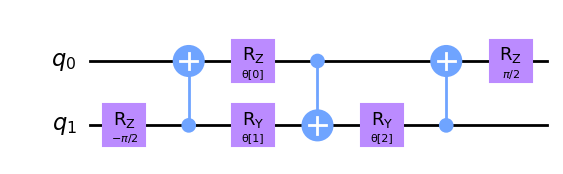

In [25]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

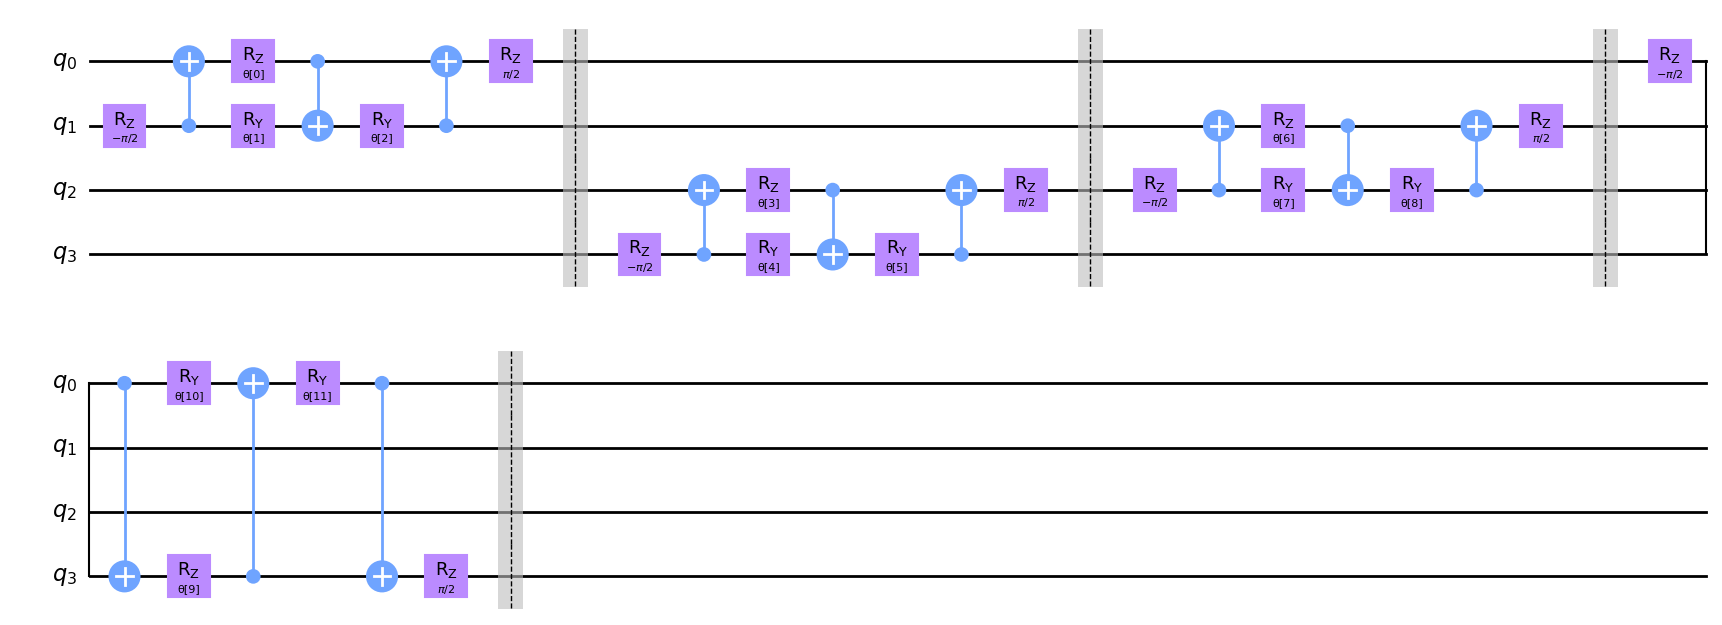

In [26]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

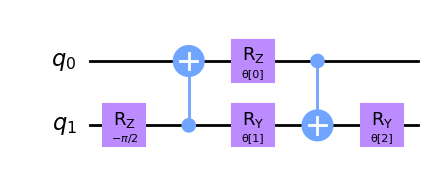

In [27]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

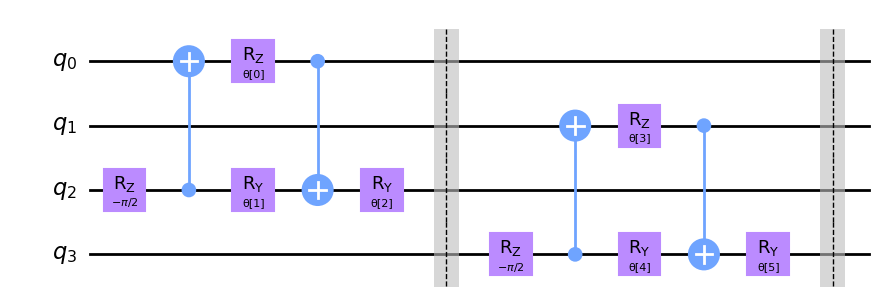

In [28]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [29]:
# def generate_dataset(num_images):
#     images = []
#     labels = []
#     hor_array = np.zeros((6, 8))
#     ver_array = np.zeros((4, 8))

#     j = 0
#     for i in range(0, 7):
#         if i != 3:
#             hor_array[j][i] = np.pi / 2
#             hor_array[j][i + 1] = np.pi / 2
#             j += 1

#     j = 0
#     for i in range(0, 4):
#         ver_array[j][i] = np.pi / 2
#         ver_array[j][i + 4] = np.pi / 2
#         j += 1

#     for n in range(num_images):
#         rng = algorithm_globals.random.integers(0, 2)
#         if rng == 0:
#             labels.append(-1)
#             random_image = algorithm_globals.random.integers(0, 6)
#             images.append(np.array(hor_array[random_image]))
#         elif rng == 1:
#             labels.append(1)
#             random_image = algorithm_globals.random.integers(0, 4)
#             images.append(np.array(ver_array[random_image]))

#         # Create noise
#         for i in range(8):
#             if images[-1][i] == 0:
#                 images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
#     return images, labels

#images, labels = generate_dataset(50)

In [30]:
# train_images, test_images, train_labels, test_labels = train_test_split(
#     images, labels, test_size=0.3, random_state=246
# )

# train_images_list = []
# train_labels_list = []
# test_images_list = []
# test_labels_list = []

# for images, labels in ds_train.unbatch():
#     train_images_list.append(images.numpy().flatten())
#     train_labels_list.append(labels.numpy())

# for images, labels in ds_test.unbatch():
#     test_images_list.append(images.numpy().flatten())
#     test_labels_list.append(labels.numpy())

# train_images = np.array(train_images_list)
# train_labels = np.array(train_labels_list)
# test_images = np.array(test_images_list)
# test_labels = np.array(test_labels_list)

# train_labels = np.where(train_labels < 5, -1, 1)
# test_labels = np.where(test_labels < 5, -1, 1)

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

# Binario: <5 vs >=5
train_labels = np.where(train_labels < 5, -1, 1)
test_labels = np.where(test_labels < 5, -1, 1)

In [31]:
# Reducir dimensionalidad (784 -> n_qubits) con SVD y mapear a ángulos
n_qubits = 8  # prueba con 8 (muy recomendable para simulación Statevector)
n_train = 700
n_test = 300

rng = np.random.default_rng(12345)

X_train = train_images.reshape(len(train_images), -1)  # (60000, 784)
X_test = test_images.reshape(len(test_images), -1)      # (10000, 784)

idx_train = rng.choice(len(X_train), size=n_train, replace=False)
idx_test = rng.choice(len(X_test), size=n_test, replace=False)

X_train_small = X_train[idx_train]
y_train_small = train_labels[idx_train]
train_images_small = train_images[idx_train]

X_test_small = X_test[idx_test]
y_test_small = test_labels[idx_test]
test_images_small = test_images[idx_test]

svd = TruncatedSVD(n_components=n_qubits, random_state=12345)
X_train_red = svd.fit_transform(X_train_small)
X_test_red = svd.transform(X_test_small)

# ZFeatureMap espera valores tipo "ángulo"; los llevamos a [-π, π]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_train_q = scaler.fit_transform(X_train_red)
X_test_q = scaler.transform(X_test_red)

print("X_train_q:", X_train_q.shape, "X_test_q:", X_test_q.shape)
print("Explained variance ratio (sum):", float(svd.explained_variance_ratio_.sum()))

X_train_q: (700, 8) X_test_q: (300, 8)
Explained variance ratio (sum): 0.44595950841903687


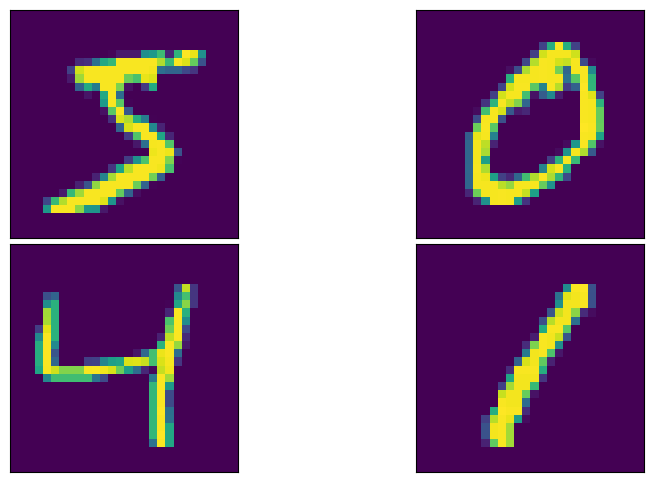

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(28, 28),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

C:\Users\BlackKnight\AppData\Local\Temp\ipykernel_24552\4026696723.py:1: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(n_qubits)


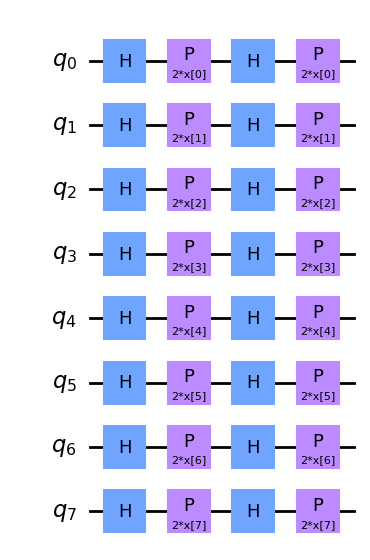

In [33]:
feature_map = ZFeatureMap(n_qubits)
feature_map.decompose().draw("mpl", style="clifford")

In [34]:
def build_qcnn(start_qubits: int, stages: int) -> QuantumCircuit:

    ansatz = QuantumCircuit(start_qubits, name="Ansatz")
    # bloque activo: lista de índices globales que actualmente forman la entrada
    active = list(range(start_qubits))

    for s in range(stages):
        # aplicar capa convolucional sobre el bloque activo
        ansatz.compose(conv_layer(len(active), f"c{s+1}"), active, inplace=True)

        # si no se puede dividir más, salir
        if len(active) < 2:
            break

        # dividir el bloque activo (global) en dos mitades
        half = len(active) // 2
        superior_global = active[half:]

        # IMPORTANTE: pool_layer se define en coordenadas locales 0..len(active)-1
        inferior_local = list(range(half))
        superior_local = list(range(half, len(active)))

        # aplicar pooling sobre el bloque activo (mapeando local->global con `active`)
        ansatz.compose(
            pool_layer(inferior_local, superior_local, f"p{s+1}"),
            active,
            inplace=True,
        )

        # actualizar bloque activo a la mitad superior (global) para la siguiente etapa
        active = superior_global

    return ansatz

In [35]:
# ansatz = QuantumCircuit(8, name="Ansatz")

# # First Convolutional Layer
# ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# # First Pooling Layer
# ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# # Second Convolutional Layer
# ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# # Second Pooling Layer
# ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# # Third Convolutional Layer
# ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# # Third Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

input_qubits = n_qubits
stages = int(np.log2(input_qubits))

ansatz = build_qcnn(start_qubits=input_qubits, stages=stages)
print(ansatz.num_qubits)

# Combining the feature map and ansatz
circuit = QuantumCircuit(input_qubits)
circuit.compose(feature_map, range(input_qubits), inplace=True)
circuit.compose(ansatz, range(input_qubits), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * (input_qubits - 1), 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


8


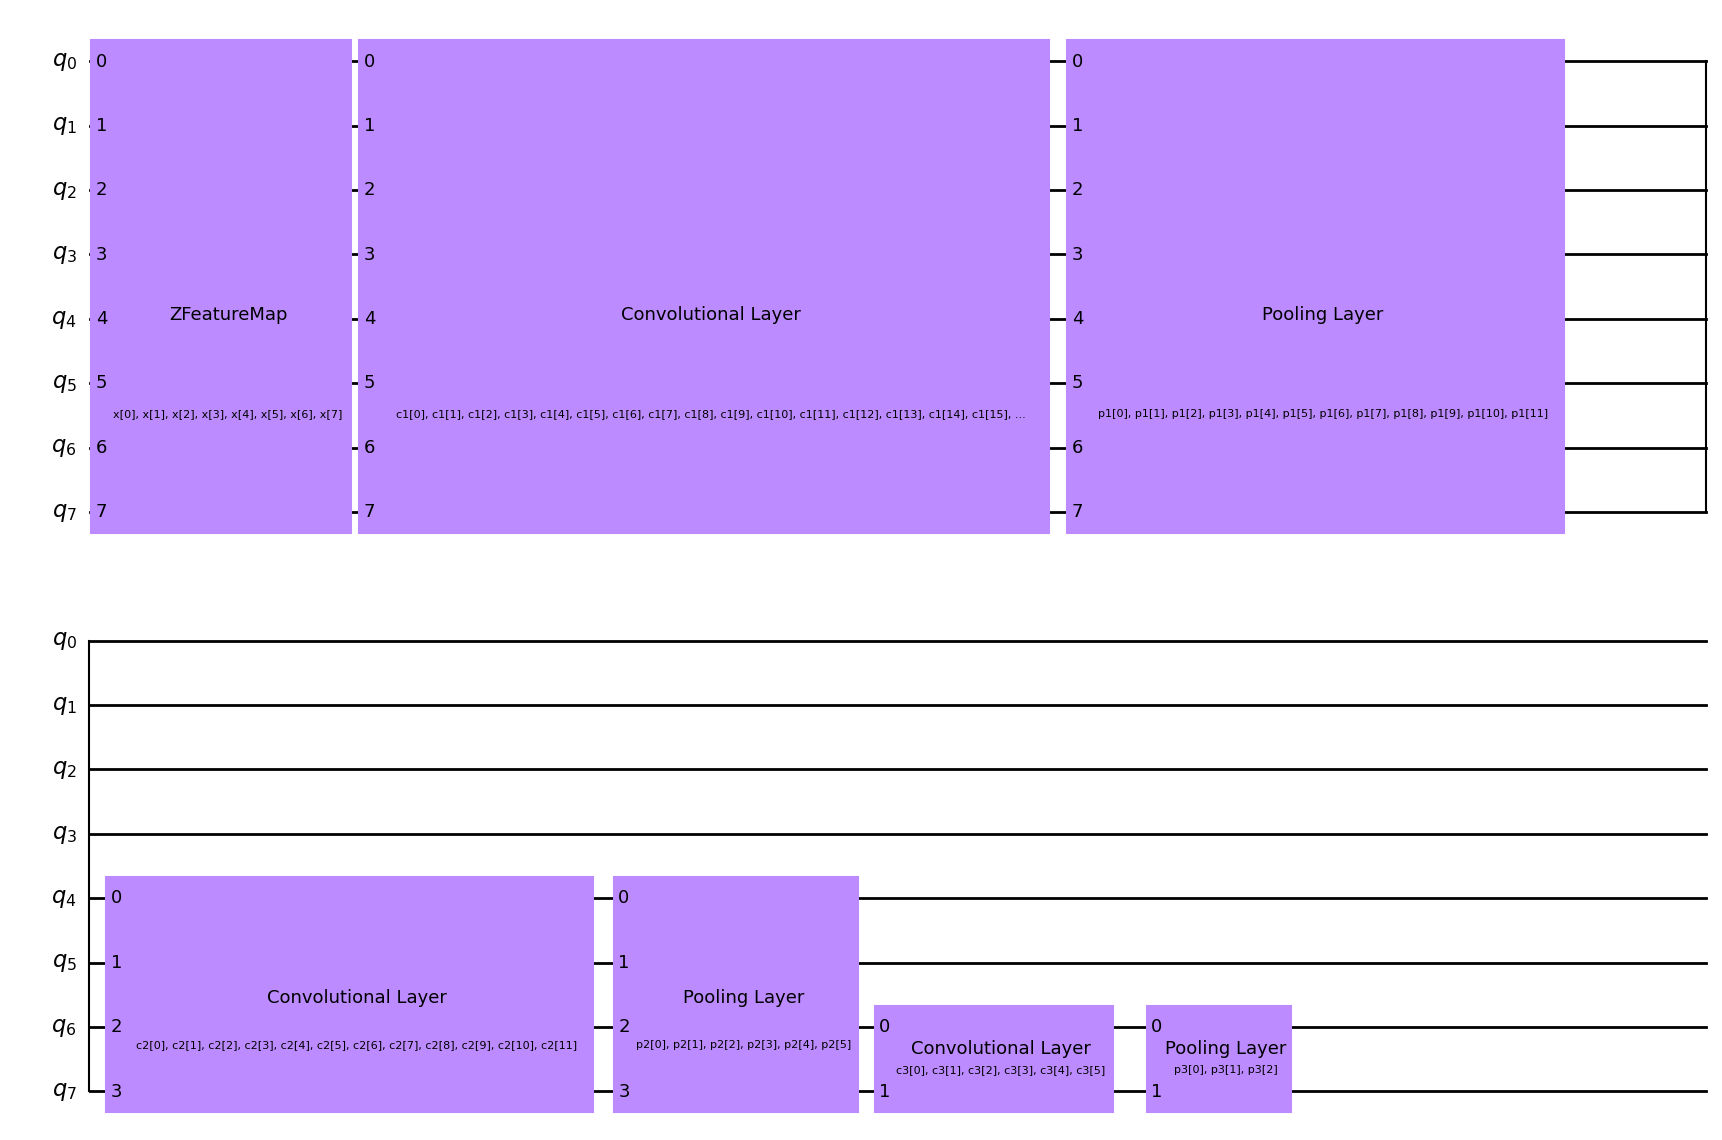

In [36]:
circuit.draw("mpl", style="clifford")

In [37]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [38]:
# with open("11_qcnn_initial_point.json", "r") as f:
#     initial_point = json.load(f)["params"]

maxiter = 40  # súbelo cuando ya te funcione el pipeline end-to-end

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=maxiter),
    callback=callback_graph,
    #initial_point=initial_point,
)

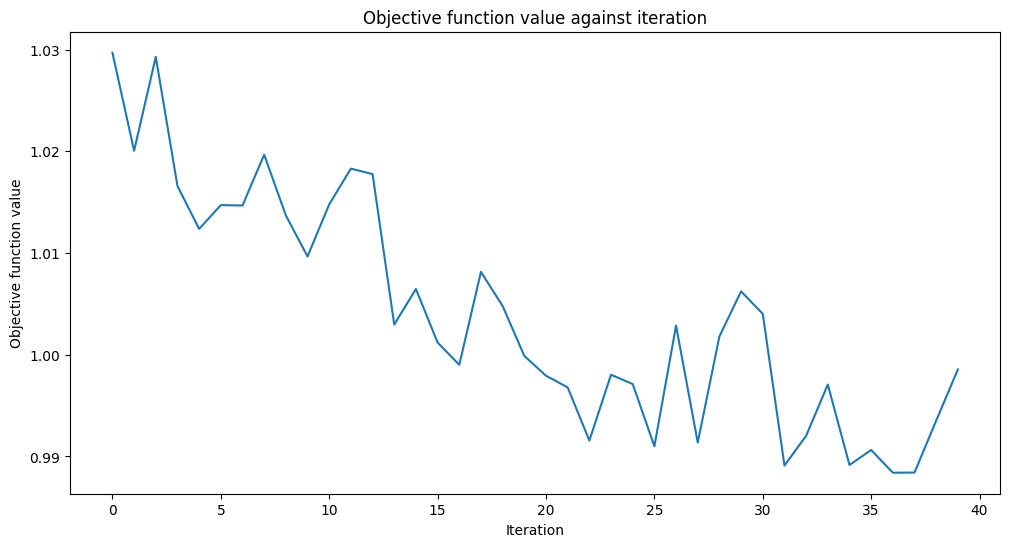

Accuracy from the train data : 55.43%


In [39]:
x = np.asarray(X_train_q)
y = np.asarray(y_train_small)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy: 0.5433
Balanced accuracy: 0.5422
Cohen kappa: 0.0845
Precision: 0.5248 | Recall: 0.5139 | F1: 0.5193
Confusion matrix (labels [-1, +1]):
 [[89 67]
 [70 74]]
Métricas guardadas en: c:\Users\BlackKnight\Desktop\uni\TFG\metrics_qcnn_mnist_wo_iterations.csv


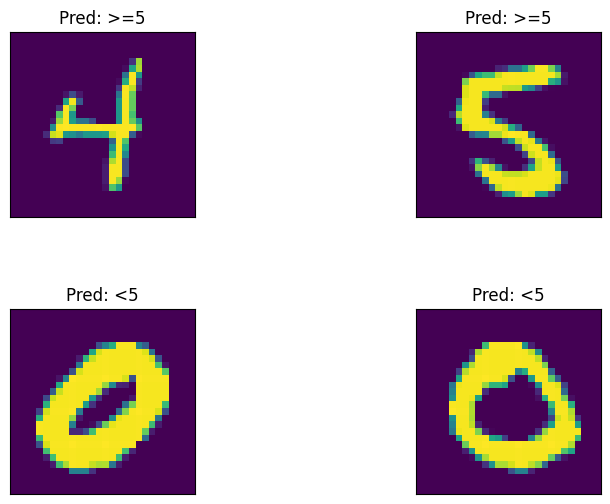

In [41]:
x_test = np.asarray(X_test_q)
y_test = np.asarray(y_test_small)

y_predict = classifier.predict(x_test)

acc = accuracy_score(y_test, y_predict)
bal_acc = balanced_accuracy_score(y_test, y_predict)
kappa = cohen_kappa_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, pos_label=1)
recall = recall_score(y_test, y_predict, pos_label=1)
f1 = f1_score(y_test, y_predict, pos_label=1)

cm = confusion_matrix(y_test, y_predict, labels=[-1, 1])
tn, fp, fn, tp = cm.ravel()

print(f"Accuracy: {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Cohen kappa: {kappa:.4f}")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
print("Confusion matrix (labels [-1, +1]):\n", cm)

csv_path = "metrics_qcnn_mnist_wo_iterations.csv"
fieldnames = [
    "timestamp",
    "n_qubits",
    "n_train",
    "n_test",
    "maxiter",
    "accuracy",
    "balanced_accuracy",
    "kappa",
    "precision",
    "recall",
    "f1",
    "tn",
    "fp",
    "fn",
    "tp",
    "explained_variance_sum",
 ]

row = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "n_qubits": int(n_qubits),
    "n_train": int(n_train),
    "n_test": int(n_test),
    "maxiter": int(maxiter),
    "accuracy": float(acc),
    "balanced_accuracy": float(bal_acc),
    "kappa": float(kappa),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1),
    "tn": int(tn),
    "fp": int(fp),
    "fn": int(fn),
    "tp": int(tp),
    "explained_variance_sum": float(svd.explained_variance_ratio_.sum()),
 }

write_header = not os.path.exists(csv_path)
with open(csv_path, "a", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if write_header:
        writer.writeheader()
    writer.writerow(row)

print(f"Métricas guardadas en: {os.path.abspath(csv_path)}")

# Ver algunos ejemplos del test (clasificación binaria <5 vs >=5)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(test_images_small[i].reshape(28, 28), aspect="equal")
    ax[i // 2, i % 2].set_title("Pred: <5" if y_predict[i] == -1 else "Pred: >=5")
plt.subplots_adjust(wspace=0.1, hspace=0.5)